# **Importing Libraries**

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss, ccf
from scipy.stats import pearsonr, normaltest, skew, kurtosis
from scipy.signal import find_peaks
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
import warnings

warnings.filterwarnings('ignore')

# Enhanced plot settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 150

# [Drive Google Drive Link](https://drive.google.com/drive/folders/1yEbRemo_5eIuVM-Ps_ZQHOTPpi6yGUJQ?usp=drive_link)

# Loading Dataset

In [34]:
print("="*80)
print("M5 WALMART - ENHANCED EDA")
print("="*80)

# Load data
data_path = "/kaggle/input/explorartory-data-analysis/data_preprocessed.parquet"
df = pd.read_parquet(data_path)

print(f"\n Data Loaded: {df.shape}")
print(f"  Date Range: {df['date'].min()} to {df['date'].max()}")
print(f"  Total Days: {(df['date'].max() - df['date'].min()).days}")

M5 WALMART - ENHANCED EDA

 Data Loaded: (59181090, 22)
  Date Range: 2011-01-29 00:00:00 to 2016-05-22 00:00:00
  Total Days: 1940


# **COMPREHENSIVE STATISTICAL SUMMARY**

In [35]:
print("\n" + "="*80)
print(" SECTION 1: STATISTICAL SUMMARY")
print("="*80)

# Basic statistics
print("\n1.1 Descriptive Statistics:")
print("-" * 80)
stats_cols = ['sold_qty', 'sell_price']
print(df[stats_cols].describe())

# Missing values analysis
print("\n1.2 Missing Values Analysis:")
print("-" * 80)
missing = df.isnull().sum()
missing_pct = (missing / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing_Count': missing,
    'Percentage': missing_pct
}).sort_values('Missing_Count', ascending=False)
print(missing_df[missing_df['Missing_Count'] > 0])

# Data types and memory
print("\n1.3 Data Types & Memory Usage:")
print("-" * 80)
print(df.dtypes.value_counts())
print(f"\nTotal Memory: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Unique values
print("\n1.4 Unique Values:")
print("-" * 80)
categorical = ['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']
for col in categorical:
    if col in df.columns:
        print(f"  {col}: {df[col].nunique():,} unique values")



 SECTION 1: STATISTICAL SUMMARY

1.1 Descriptive Statistics:
--------------------------------------------------------------------------------
           sold_qty    sell_price
count  5.832737e+07  5.918109e+07
mean   1.126322e+00  4.446684e+00
std    3.873108e+00  3.519913e+00
min    0.000000e+00  1.000000e-02
25%    0.000000e+00  2.180000e+00
50%    0.000000e+00  3.420000e+00
75%    1.000000e+00  5.840000e+00
max    7.630000e+02  1.073200e+02

1.2 Missing Values Analysis:
--------------------------------------------------------------------------------
              Missing_Count  Percentage
event_type_2       59059130   99.793921
event_name_2       59059130   99.793921
event_type_1       54363670   91.859866
event_name_1       54363670   91.859866
sold_qty             853720    1.442555

1.3 Data Types & Memory Usage:
--------------------------------------------------------------------------------
object            4
bool              3
int8              2
int16             2
categor

# **DAILY SALES ANALYSIS**


 SECTION 2: DAILY SALES ANALYSIS

2.1 Daily Sales Statistics:
--------------------------------------------------------------------------------
  Mean: 33,846.17
  Median: 33,611.00
  Std Dev: 8,364.17
  Min: 0.00
  Max: 57,218.00
  Skewness: -0.796
  Kurtosis: 3.069

  Normality Test (D'Agostino):
    Statistic: 307.4791
    P-value: 0.0000
    Result: Not Normal


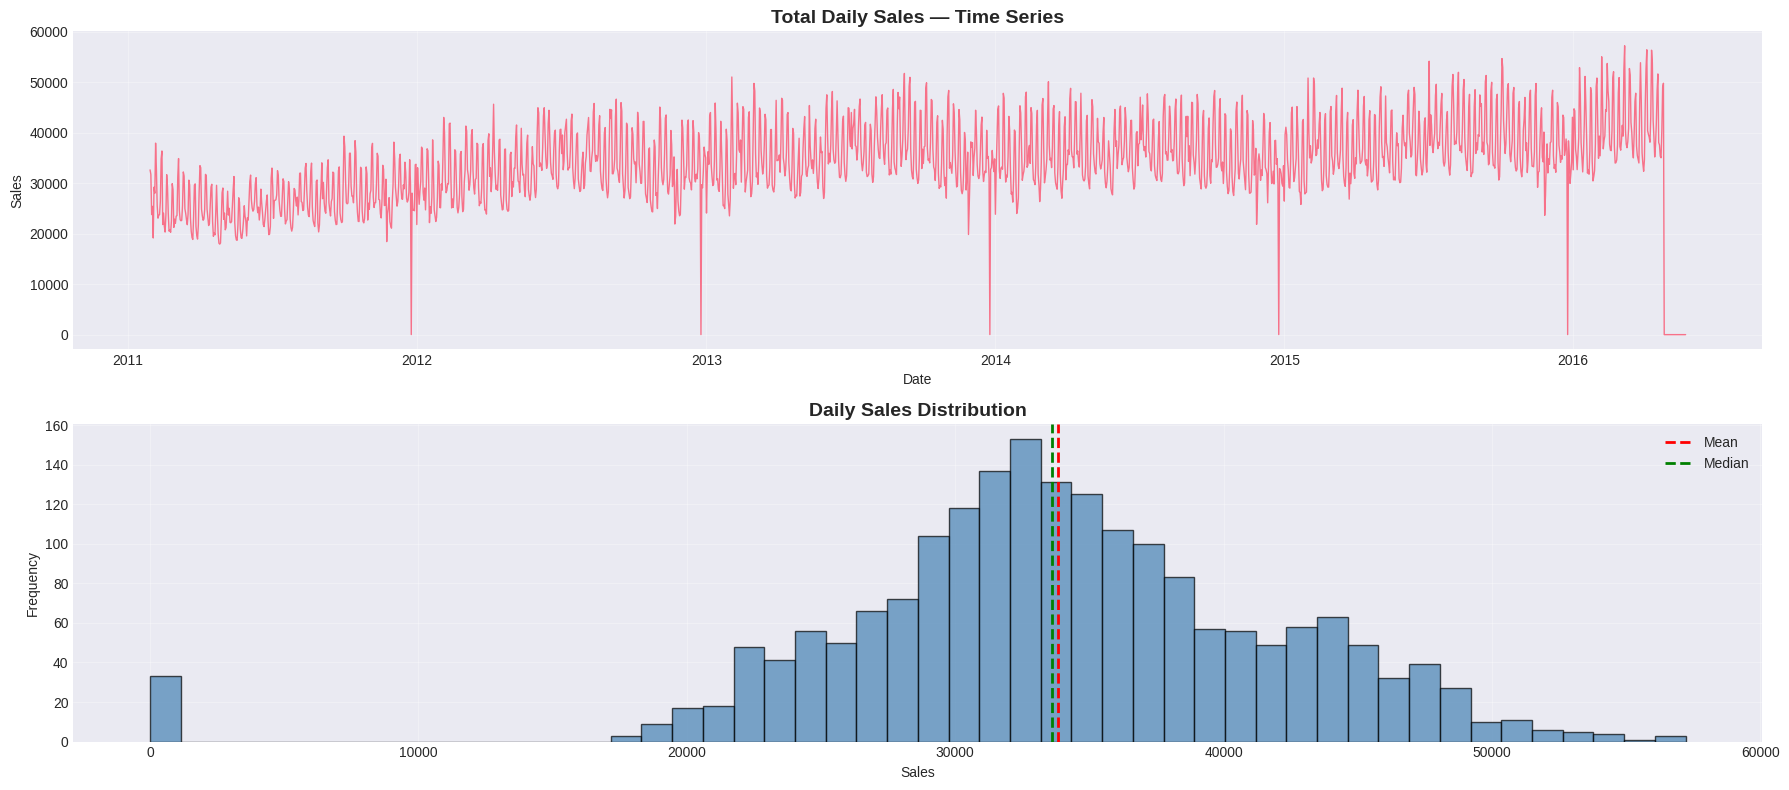


 Saved: 01_daily_sales_overview.png


In [36]:
print("\n" + "="*80)
print(" SECTION 2: DAILY SALES ANALYSIS")
print("="*80)

# Aggregate daily sales
df["date"] = pd.to_datetime(df["date"])
daily = df.groupby("date")["sold_qty"].sum().to_frame("sales")
daily.index = pd.to_datetime(daily.index)

print(f"\n2.1 Daily Sales Statistics:")
print("-" * 80)
print(f"  Mean: {daily.sales.mean():,.2f}")
print(f"  Median: {daily.sales.median():,.2f}")
print(f"  Std Dev: {daily.sales.std():,.2f}")
print(f"  Min: {daily.sales.min():,.2f}")
print(f"  Max: {daily.sales.max():,.2f}")
print(f"  Skewness: {skew(daily.sales):.3f}")
print(f"  Kurtosis: {kurtosis(daily.sales):.3f}")

# Normality test
stat, p_value = normaltest(daily.sales)
print(f"\n  Normality Test (D'Agostino):")
print(f"    Statistic: {stat:.4f}")
print(f"    P-value: {p_value:.4f}")
print(f"    Result: {'Normal' if p_value > 0.05 else 'Not Normal'}")

# Plot daily sales
fig, axes = plt.subplots(2, 1, figsize=(18, 8))

axes[0].plot(daily.index, daily.sales, linewidth=1)
axes[0].set_title("Total Daily Sales — Time Series", fontsize=14, fontweight='bold')
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Sales")
axes[0].grid(alpha=0.3)

# Distribution
axes[1].hist(daily.sales, bins=50, alpha=0.7, color='steelblue', edgecolor='black')
axes[1].axvline(daily.sales.mean(), color='red', linestyle='--', linewidth=2, label='Mean')
axes[1].axvline(daily.sales.median(), color='green', linestyle='--', linewidth=2, label='Median')
axes[1].set_title("Daily Sales Distribution", fontsize=14, fontweight='bold')
axes[1].set_xlabel("Sales")
axes[1].set_ylabel("Frequency")
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()
plt.savefig('01_daily_sales_overview.png', bbox_inches='tight')
print("\n Saved: 01_daily_sales_overview.png")
plt.close()


# **TREND DECOMPOSITION (STL)**


 SECTION 3: TREND DECOMPOSITION

3.1 Decomposition Components:
--------------------------------------------------------------------------------
  Trend Strength: 0.904
  Seasonal Strength: 0.854


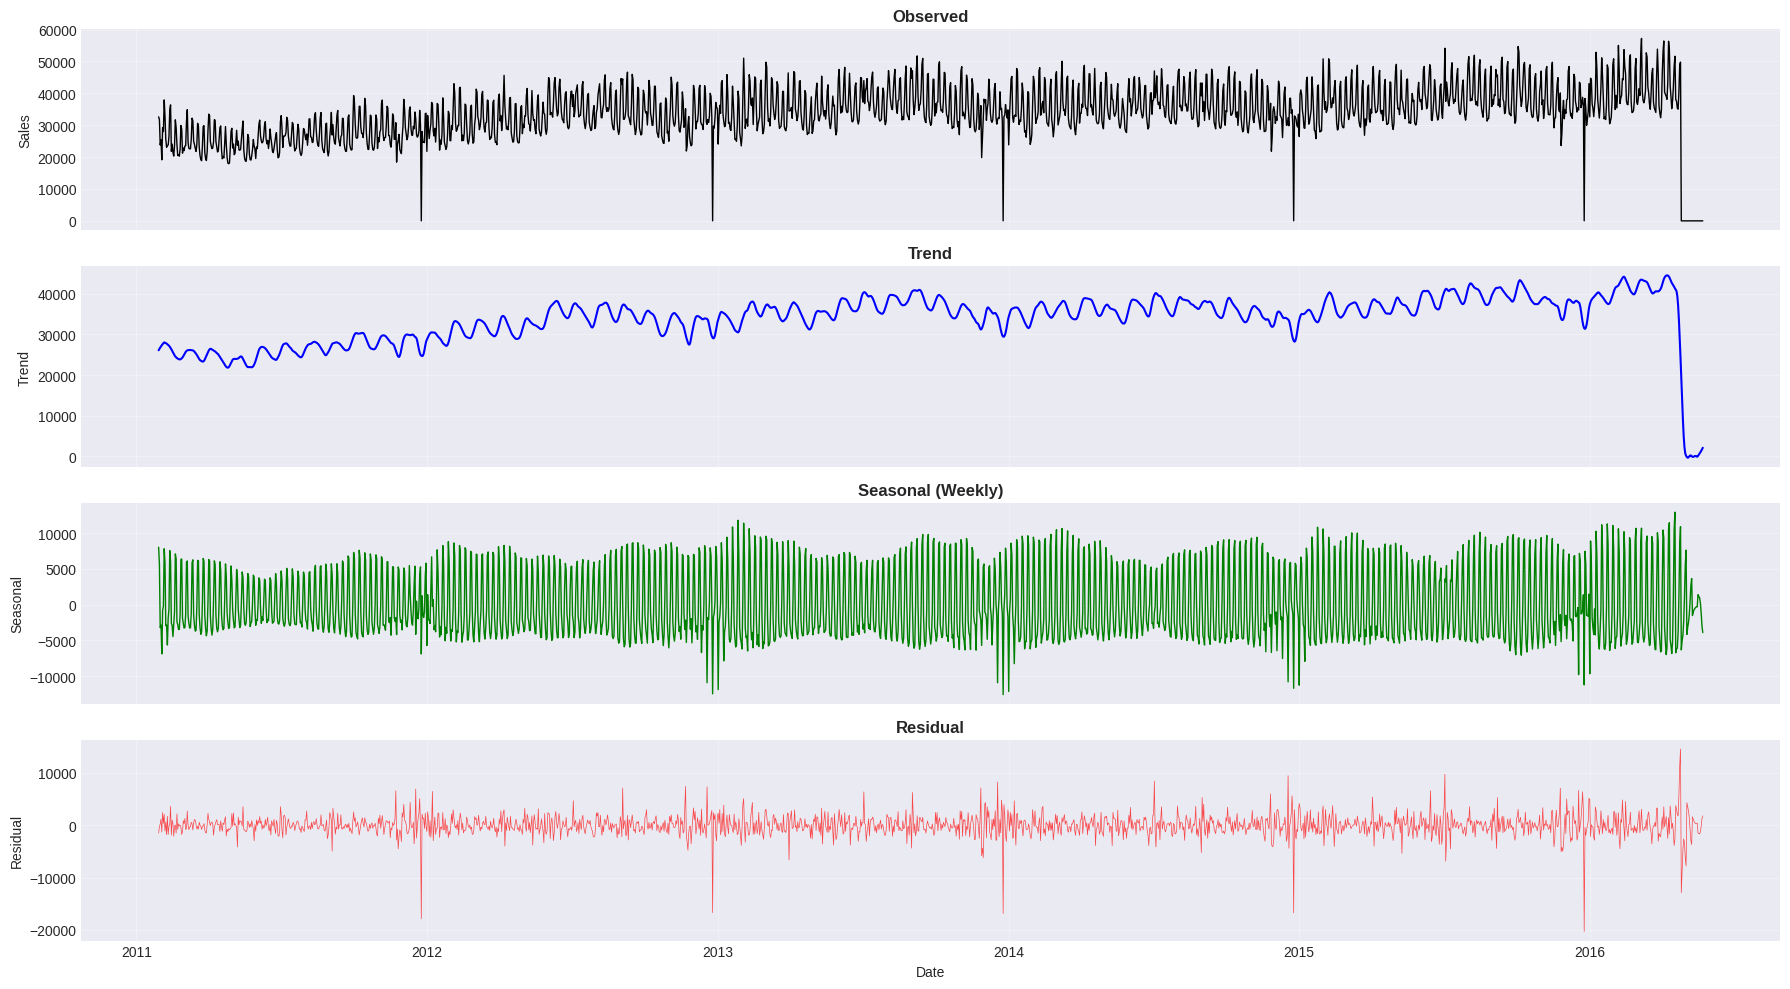


 Saved: 02_stl_decomposition.png


In [37]:
print("\n" + "="*80)
print(" SECTION 3: TREND DECOMPOSITION")
print("="*80)

stl = STL(daily.sales, period=7)
res = stl.fit()

print(f"\n3.1 Decomposition Components:")
print("-" * 80)
print(f"  Trend Strength: {1 - (res.resid.var() / (res.resid + res.trend).var()):.3f}")
print(f"  Seasonal Strength: {1 - (res.resid.var() / (res.resid + res.seasonal).var()):.3f}")

fig, axes = plt.subplots(4, 1, figsize=(18, 10), sharex=True)

axes[0].plot(daily.index, daily.sales, color='black', linewidth=1)
axes[0].set_title("Observed", fontsize=12, fontweight='bold')
axes[0].set_ylabel("Sales")
axes[0].grid(alpha=0.3)

axes[1].plot(daily.index, res.trend, color='blue', linewidth=1.5)
axes[1].set_title("Trend", fontsize=12, fontweight='bold')
axes[1].set_ylabel("Trend")
axes[1].grid(alpha=0.3)

axes[2].plot(daily.index, res.seasonal, color='green', linewidth=1)
axes[2].set_title("Seasonal (Weekly)", fontsize=12, fontweight='bold')
axes[2].set_ylabel("Seasonal")
axes[2].grid(alpha=0.3)

axes[3].plot(daily.index, res.resid, color='red', linewidth=0.5, alpha=0.7)
axes[3].set_title("Residual", fontsize=12, fontweight='bold')
axes[3].set_ylabel("Residual")
axes[3].set_xlabel("Date")
axes[3].grid(alpha=0.3)

plt.tight_layout()
plt.show()
plt.savefig('02_stl_decomposition.png', bbox_inches='tight')
print("\n Saved: 02_stl_decomposition.png")
plt.close()

#  **AUTOCORRELATION ANALYSIS (ACF/PACF)**


 SECTION 4: AUTOCORRELATION ANALYSIS


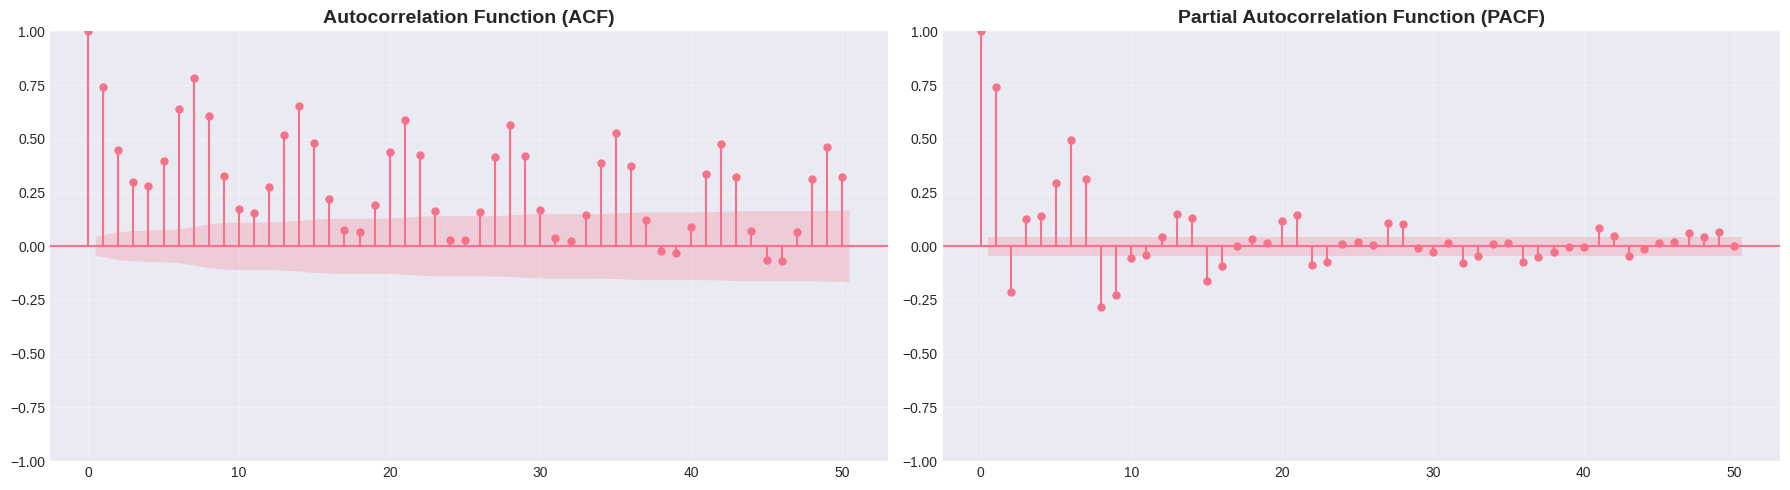


 Saved: 03_acf_pacf.png


In [38]:
print("\n" + "="*80)
print(" SECTION 4: AUTOCORRELATION ANALYSIS")
print("="*80)

fig, axes = plt.subplots(1, 2, figsize=(18, 5))

plot_acf(daily.sales, lags=50, ax=axes[0])
axes[0].set_title("Autocorrelation Function (ACF)", fontsize=14, fontweight='bold')
axes[0].grid(alpha=0.3)

plot_pacf(daily.sales, lags=50, ax=axes[1])
axes[1].set_title("Partial Autocorrelation Function (PACF)", fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()
plt.savefig('03_acf_pacf.png', bbox_inches='tight')
print("\n Saved: 03_acf_pacf.png")
plt.close()

# **SEASONALITY ANALYSIS**


 SECTION 5: SEASONALITY PATTERNS

5.1 Weekly Pattern:
--------------------------------------------------------------------------------
  Mon: 32,378.56 (Avg Sales)
  Tue: 29,930.24 (Avg Sales)
  Wed: 29,576.66 (Avg Sales)
  Thu: 29,768.83 (Avg Sales)
  Fri: 33,731.75 (Avg Sales)
  Sat: 40,949.10 (Avg Sales)
  Sun: 40,538.22 (Avg Sales)

5.2 Monthly Pattern:
--------------------------------------------------------------------------------
  Jan: 33,832.35
  Feb: 34,644.64
  Mar: 34,339.84
  Apr: 33,116.73
  May: 28,463.82
  Jun: 35,001.41
  Jul: 35,122.42
  Aug: 35,946.65
  Sep: 35,479.26
  Oct: 34,713.48
  Nov: 33,290.83
  Dec: 32,980.46


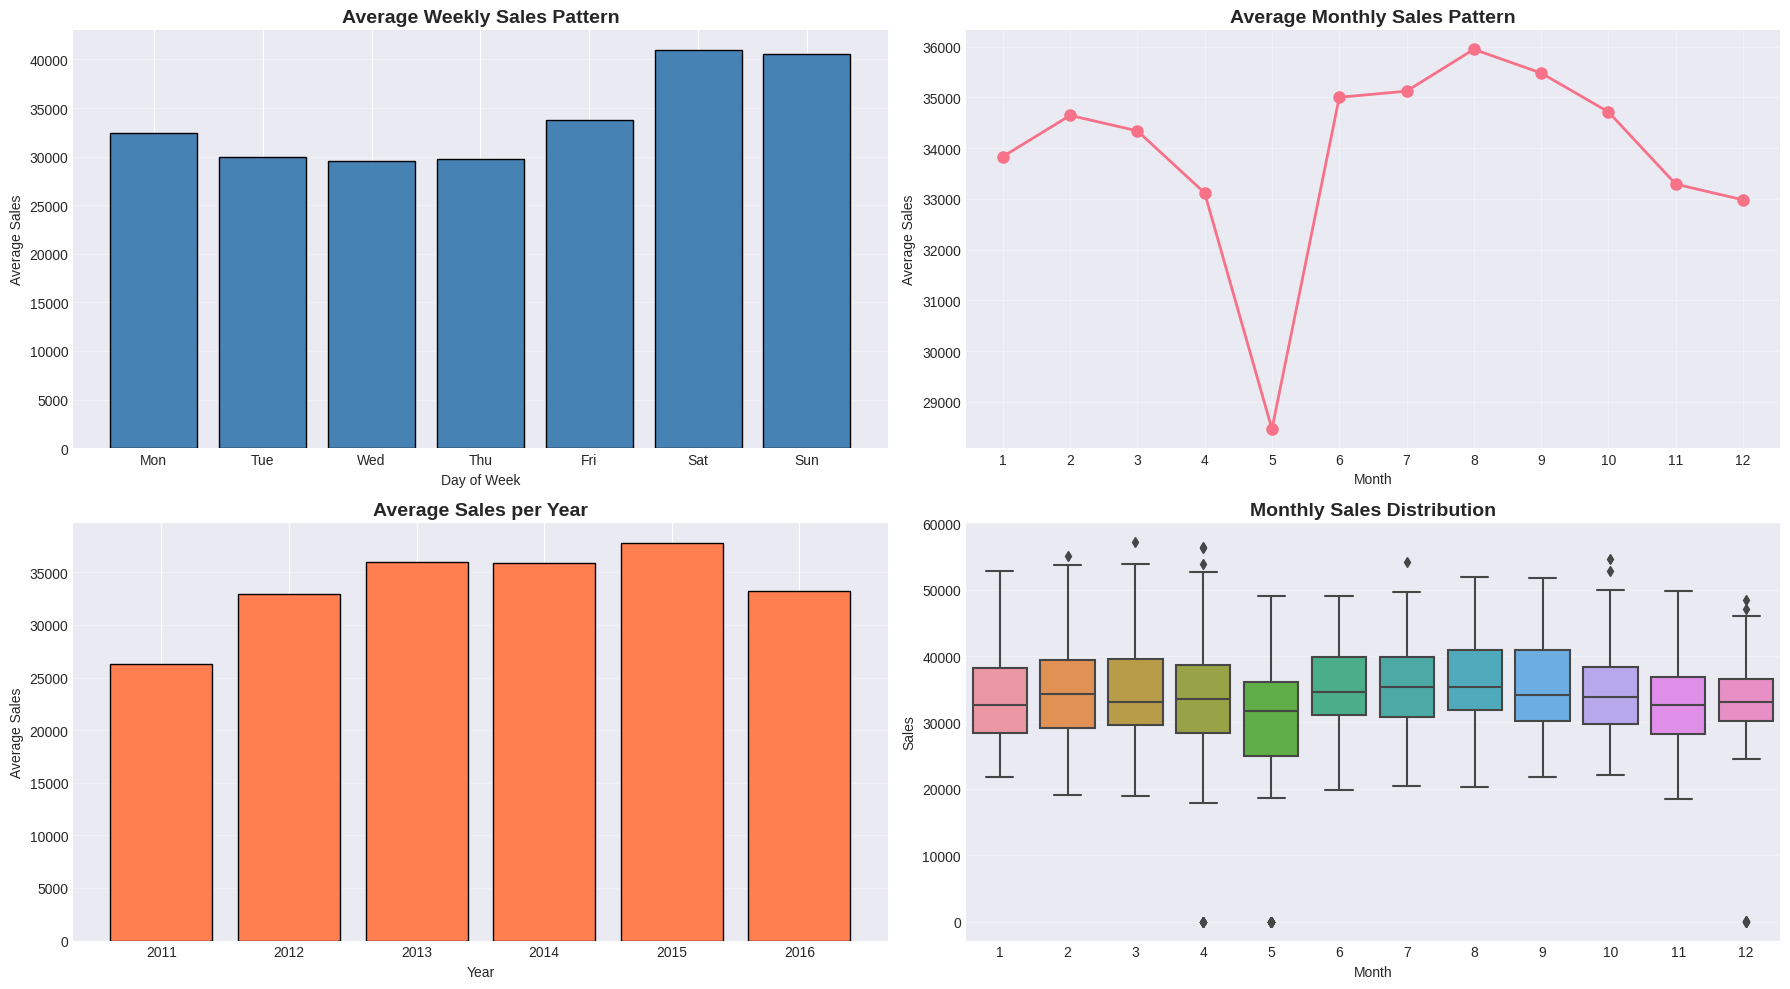


 Saved: 04_seasonality_patterns.png


In [39]:
print("\n" + "="*80)
print(" SECTION 5: SEASONALITY PATTERNS")
print("="*80)

daily["weekday"] = daily.index.dayofweek
daily["month"] = daily.index.month
daily["year"] = daily.index.year

# Weekly pattern
weekly_avg = daily.groupby("weekday")["sales"].mean()
print(f"\n5.1 Weekly Pattern:")
print("-" * 80)
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
for i, day in enumerate(days):
    print(f"  {day}: {weekly_avg.iloc[i]:,.2f} (Avg Sales)")

# Monthly pattern
monthly_avg = daily.groupby("month")["sales"].mean()
print(f"\n5.2 Monthly Pattern:")
print("-" * 80)
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
for i, month in enumerate(months, 1):
    print(f"  {month}: {monthly_avg.iloc[i-1]:,.2f}")

fig, axes = plt.subplots(2, 2, figsize=(18, 10))

# Weekly
axes[0, 0].bar(days, weekly_avg.values, color='steelblue', edgecolor='black')
axes[0, 0].set_title("Average Weekly Sales Pattern", fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel("Day of Week")
axes[0, 0].set_ylabel("Average Sales")
axes[0, 0].grid(alpha=0.3, axis='y')

# Monthly
axes[0, 1].plot(range(1, 13), monthly_avg.values, marker="o", linewidth=2, markersize=8)
axes[0, 1].set_title("Average Monthly Sales Pattern", fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel("Month")
axes[0, 1].set_ylabel("Average Sales")
axes[0, 1].set_xticks(range(1, 13))
axes[0, 1].grid(alpha=0.3)

# Yearly
yearly_avg = daily.groupby("year")["sales"].mean()
axes[1, 0].bar(yearly_avg.index, yearly_avg.values, color='coral', edgecolor='black')
axes[1, 0].set_title("Average Sales per Year", fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel("Year")
axes[1, 0].set_ylabel("Average Sales")
axes[1, 0].grid(alpha=0.3, axis='y')

# Box plot by month
sns.boxplot(x=daily.index.month, y=daily.sales, ax=axes[1, 1])
axes[1, 1].set_title("Monthly Sales Distribution", fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel("Month")
axes[1, 1].set_ylabel("Sales")
axes[1, 1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()
plt.savefig('04_seasonality_patterns.png', bbox_inches='tight')
print("\n Saved: 04_seasonality_patterns.png")
plt.close()

# **STATIONARITY TESTS**

In [40]:
print("\n" + "="*80)
print(" SECTION 6: STATIONARITY TESTS")
print("="*80)

# ADF Test
adf_result = adfuller(daily.sales)
print(f"\n6.1 Augmented Dickey-Fuller Test:")
print("-" * 80)
print(f"  ADF Statistic: {adf_result[0]:.6f}")
print(f"  P-value: {adf_result[1]:.6f}")
print(f"  Critical Values:")
for key, value in adf_result[4].items():
    print(f"    {key}: {value:.6f}")
print(f"  Result: {'Stationary' if adf_result[1] < 0.05 else 'Non-Stationary'}")

# KPSS Test
kpss_result = kpss(daily.sales, nlags="auto")
print(f"\n6.2 KPSS Test:")
print("-" * 80)
print(f"  KPSS Statistic: {kpss_result[0]:.6f}")
print(f"  P-value: {kpss_result[1]:.6f}")
print(f"  Critical Values:")
for key, value in kpss_result[3].items():
    print(f"    {key}: {value:.6f}")
print(f"  Result: {'Non-Stationary' if kpss_result[1] < 0.05 else 'Stationary'}")



 SECTION 6: STATIONARITY TESTS

6.1 Augmented Dickey-Fuller Test:
--------------------------------------------------------------------------------
  ADF Statistic: -0.199116
  P-value: 0.938627
  Critical Values:
    1%: -3.433771
    5%: -2.863051
    10%: -2.567575
  Result: Non-Stationary

6.2 KPSS Test:
--------------------------------------------------------------------------------
  KPSS Statistic: 2.609768
  P-value: 0.010000
  Critical Values:
    10%: 0.347000
    5%: 0.463000
    2.5%: 0.574000
    1%: 0.739000
  Result: Non-Stationary


# **EVENT IMPACT ANALYSIS**


 SECTION 7: EVENT IMPACT ANALYSIS

7.1 Event vs Normal Days:
--------------------------------------------------------------------------------
                  mean   median           std  count
is_event                                            
0         34024.966910  33634.0   8124.589414   1783
1         31828.436709  33537.0  10525.370429    158

  Sales Uplift on Event Days: -6.46%


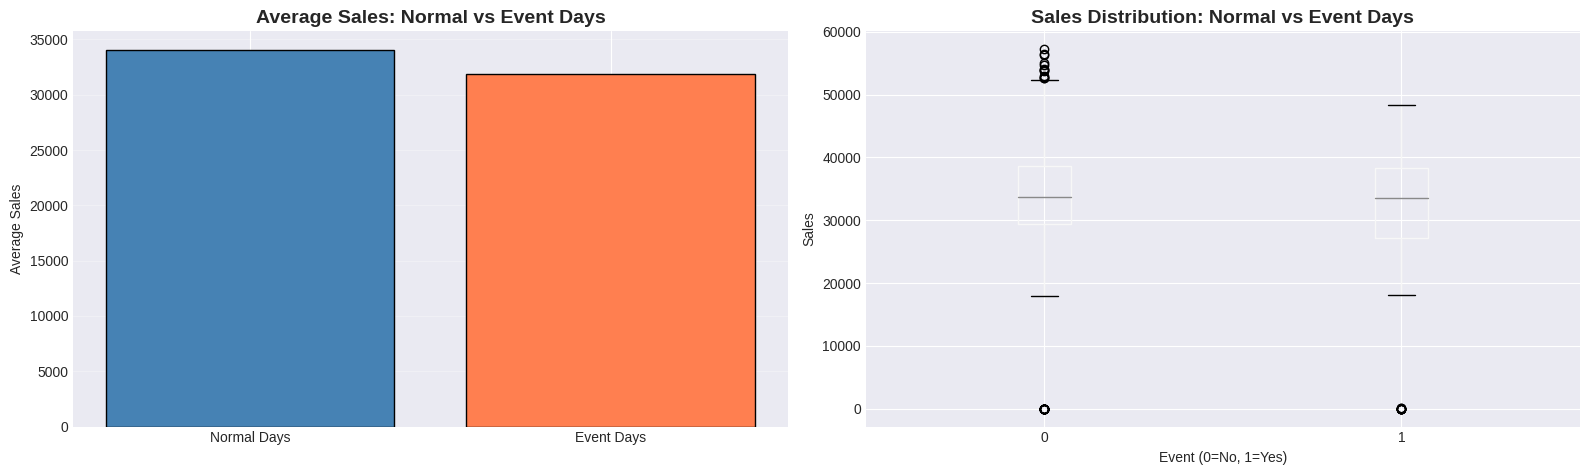


 Saved: 05_event_impact.png


In [41]:

print("\n" + "="*80)
print(" SECTION 7: EVENT IMPACT ANALYSIS")
print("="*80)

event_daily = df.groupby(["date", "event_name_1"])["sold_qty"].sum().reset_index()
merge = daily.reset_index().merge(event_daily, on="date", how="left")
merge["is_event"] = merge["event_name_1"].notna().astype(int)

event_effect = merge.groupby("is_event")["sales"].agg(['mean', 'median', 'std', 'count'])
print(f"\n7.1 Event vs Normal Days:")
print("-" * 80)
print(event_effect)

uplift = ((event_effect.loc[1, 'mean'] - event_effect.loc[0, 'mean']) / event_effect.loc[0, 'mean']) * 100
print(f"\n  Sales Uplift on Event Days: {uplift:.2f}%")

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Bar plot
axes[0].bar(["Normal Days", "Event Days"], event_effect['mean'].values, 
            color=['steelblue', 'coral'], edgecolor='black')
axes[0].set_title("Average Sales: Normal vs Event Days", fontsize=14, fontweight='bold')
axes[0].set_ylabel("Average Sales")
axes[0].grid(alpha=0.3, axis='y')

# Box plot
merge.boxplot(column='sales', by='is_event', ax=axes[1])
axes[1].set_title("Sales Distribution: Normal vs Event Days", fontsize=14, fontweight='bold')
axes[1].set_xlabel("Event (0=No, 1=Yes)")
axes[1].set_ylabel("Sales")
plt.suptitle("")

plt.tight_layout()
plt.show()
plt.savefig('05_event_impact.png', bbox_inches='tight')
print("\n Saved: 05_event_impact.png")
plt.close()

# **CORRELATION ANALYSIS**


 SECTION 8: CORRELATION ANALYSIS

8.1 Top Correlations with Sales (sold_qty):
--------------------------------------------------------------------------------
  year: 0.0330
  snap_WI: 0.0133
  snap_TX: 0.0130
  snap_CA: 0.0113
  month: -0.0002
  wday: -0.0283
  sell_price: -0.1311


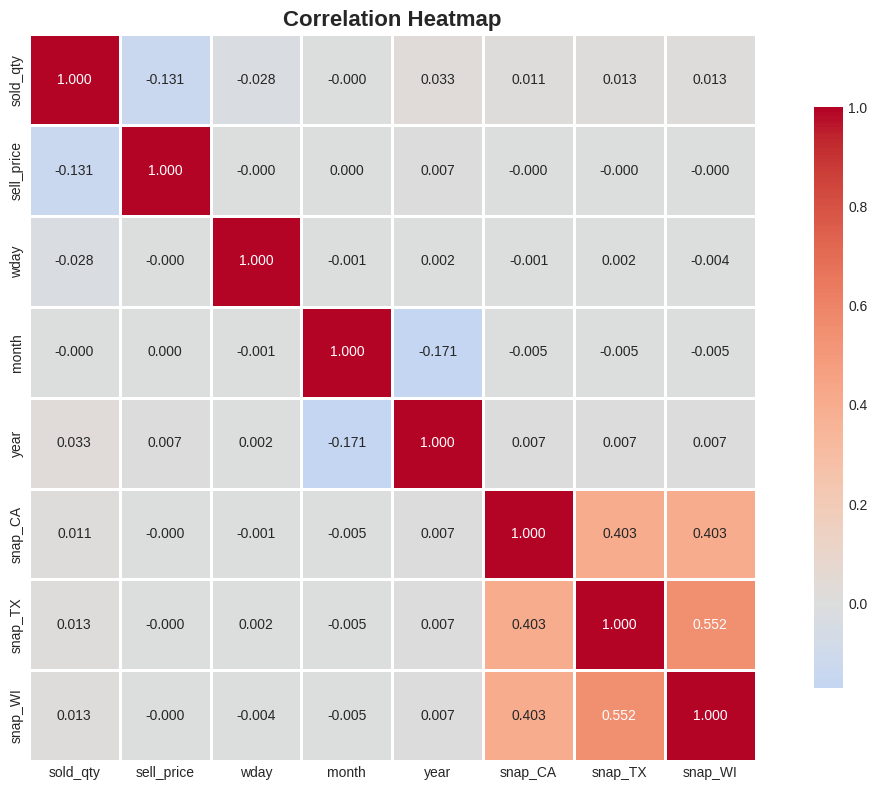


 Saved: 06_correlation_heatmap.png


In [42]:
print("\n" + "="*80)
print(" SECTION 8: CORRELATION ANALYSIS")
print("="*80)

num_cols = ["sold_qty", "sell_price", "wday", "month", "year", "snap_CA", "snap_TX", "snap_WI"]
corr = df[num_cols].corr()

print(f"\n8.1 Top Correlations with Sales (sold_qty):")
print("-" * 80)
sales_corr = corr['sold_qty'].sort_values(ascending=False)
for col, val in sales_corr.items():
    if col != 'sold_qty':
        print(f"  {col}: {val:.4f}")

plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, fmt='.3f', cmap="coolwarm", center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title("Correlation Heatmap", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()
plt.savefig('06_correlation_heatmap.png', bbox_inches='tight')
print("\n Saved: 06_correlation_heatmap.png")
plt.close()

# **OUTLIER DETECTION**


 SECTION 9: OUTLIER DETECTION

9.1 Outlier Statistics (IQR Method):
--------------------------------------------------------------------------------
  Q1: 29,410.00
  Q3: 38,564.00
  IQR: 9,154.00
  Lower Bound: 15,679.00
  Upper Bound: 52,295.00
  Outliers Detected: 47 (2.42%)


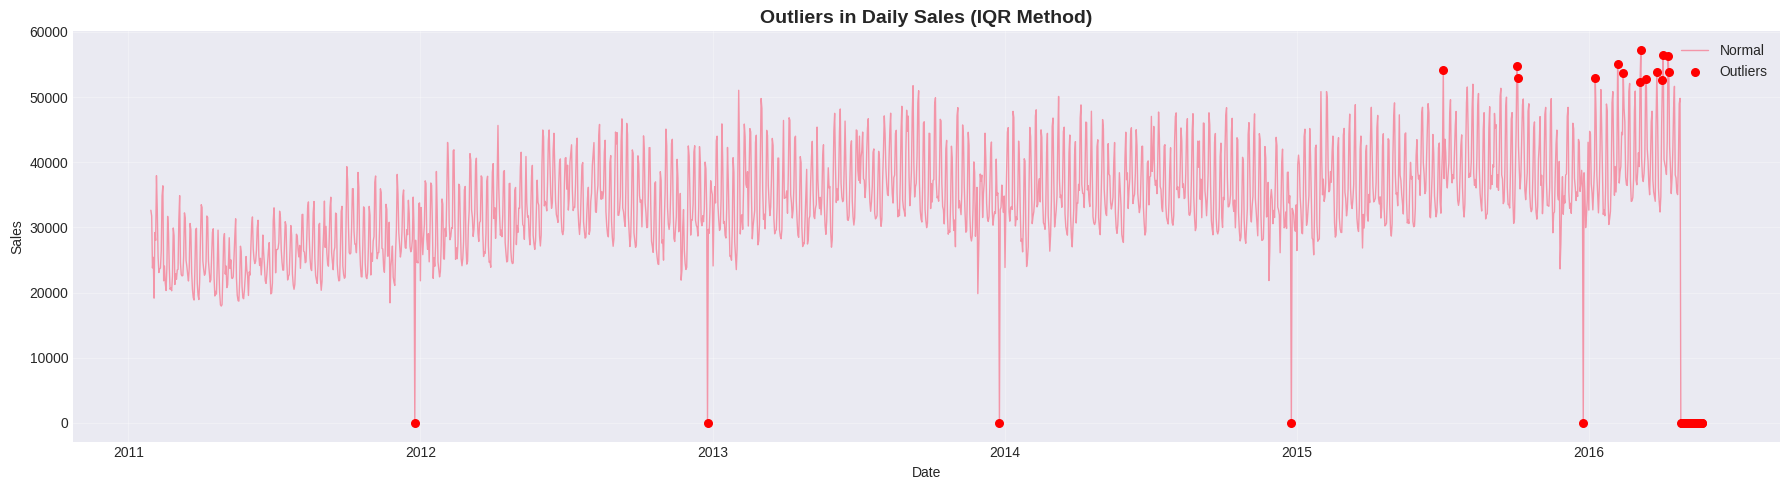


 Saved: 07_outliers.png


In [43]:
print("\n" + "="*80)
print(" SECTION 9: OUTLIER DETECTION")
print("="*80)

Q1 = daily.sales.quantile(0.25)
Q3 = daily.sales.quantile(0.75)
IQR = Q3 - Q1

outliers = daily[(daily.sales < Q1 - 1.5*IQR) | (daily.sales > Q3 + 1.5*IQR)]

print(f"\n9.1 Outlier Statistics (IQR Method):")
print("-" * 80)
print(f"  Q1: {Q1:,.2f}")
print(f"  Q3: {Q3:,.2f}")
print(f"  IQR: {IQR:,.2f}")
print(f"  Lower Bound: {Q1 - 1.5*IQR:,.2f}")
print(f"  Upper Bound: {Q3 + 1.5*IQR:,.2f}")
print(f"  Outliers Detected: {len(outliers)} ({len(outliers)/len(daily)*100:.2f}%)")

plt.figure(figsize=(18, 5))
plt.plot(daily.index, daily.sales, linewidth=1, alpha=0.7, label='Normal')
plt.scatter(outliers.index, outliers.sales, color="red", s=30, label='Outliers', zorder=5)
plt.title("Outliers in Daily Sales (IQR Method)", fontsize=14, fontweight='bold')
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
plt.savefig('07_outliers.png', bbox_inches='tight')
print("\n Saved: 07_outliers.png")
plt.close()


# **TOP PERFORMERS ANALYSIS**


 SECTION 10: TOP PERFORMERS ANALYSIS

10.1 Top 10 Items by Total Sales:
--------------------------------------------------------------------------------
  1. FOODS_3_090: 1,002,529 units
  2. FOODS_3_586: 920,242 units
  3. FOODS_3_252: 565,299 units
  4. FOODS_3_555: 491,287 units
  5. FOODS_3_714: 396,172 units
  6. FOODS_3_587: 396,119 units
  7. FOODS_3_694: 390,001 units
  8. FOODS_3_226: 363,082 units
  9. FOODS_3_202: 295,689 units
  10. FOODS_3_723: 284,333 units

10.2 Top Stores by Total Sales:
--------------------------------------------------------------------------------
  1. CA_3: 11,188,180 units
  2. CA_1: 7,698,216 units
  3. TX_2: 7,214,384 units
  4. WI_2: 6,544,012 units
  5. WI_3: 6,427,782 units
  6. TX_3: 6,089,330 units
  7. CA_2: 5,685,475 units
  8. TX_1: 5,595,292 units
  9. WI_1: 5,149,062 units
  10. CA_4: 4,103,676 units


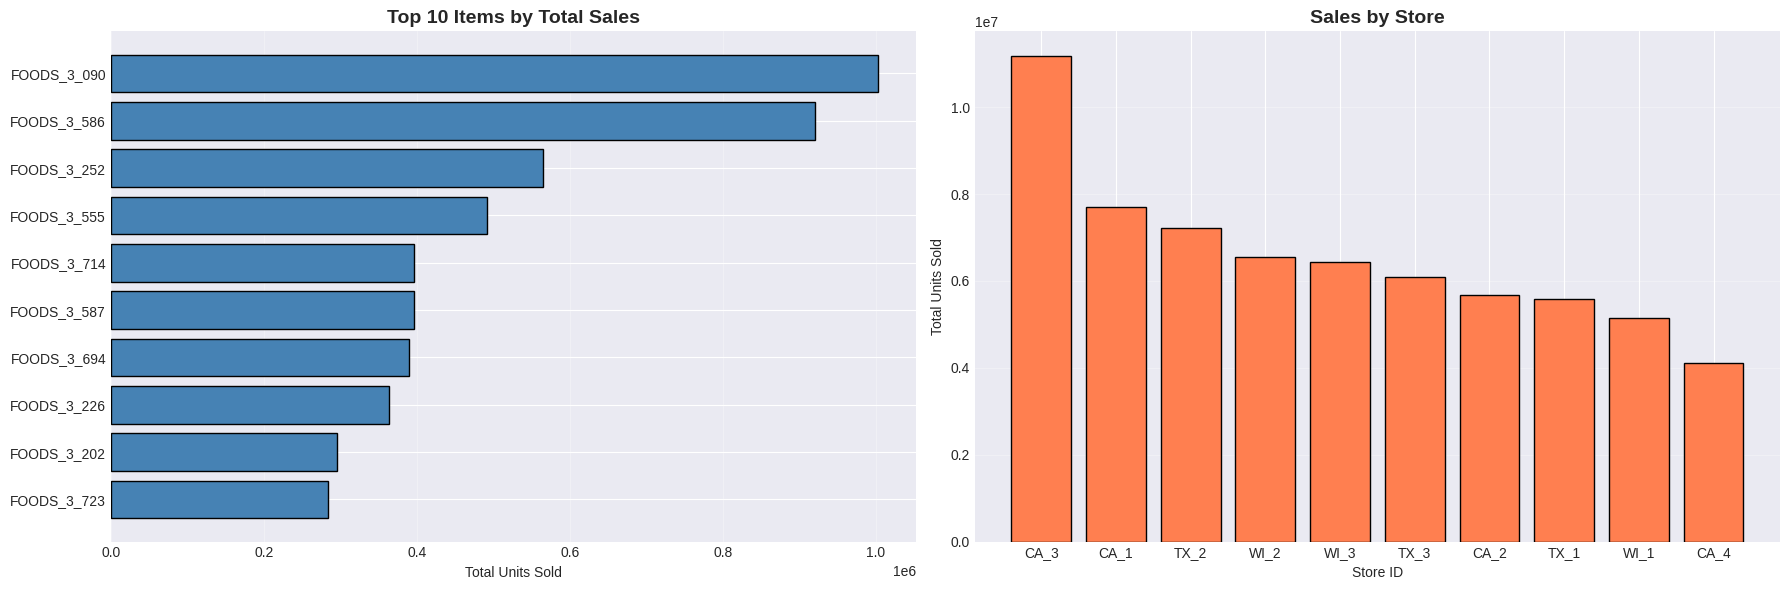


 Saved: 08_top_performers.png


In [44]:
print("\n" + "="*80)
print(" SECTION 10: TOP PERFORMERS ANALYSIS")
print("="*80)

# Top items
print(f"\n10.1 Top 10 Items by Total Sales:")
print("-" * 80)
top_items = df.groupby('item_id')['sold_qty'].sum().sort_values(ascending=False).head(10)
for i, (item, sales) in enumerate(top_items.items(), 1):
    print(f"  {i}. {item}: {sales:,.0f} units")

# Top stores
print(f"\n10.2 Top Stores by Total Sales:")
print("-" * 80)
top_stores = df.groupby('store_id')['sold_qty'].sum().sort_values(ascending=False)
for i, (store, sales) in enumerate(top_stores.items(), 1):
    print(f"  {i}. {store}: {sales:,.0f} units")

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Top items
axes[0].barh(range(10), top_items.values[::-1], color='steelblue', edgecolor='black')
axes[0].set_yticks(range(10))
axes[0].set_yticklabels(top_items.index[::-1])
axes[0].set_title("Top 10 Items by Total Sales", fontsize=14, fontweight='bold')
axes[0].set_xlabel("Total Units Sold")
axes[0].grid(alpha=0.3, axis='x')

# Top stores
axes[1].bar(top_stores.index, top_stores.values, color='coral', edgecolor='black')
axes[1].set_title("Sales by Store", fontsize=14, fontweight='bold')
axes[1].set_xlabel("Store ID")
axes[1].set_ylabel("Total Units Sold")
axes[1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()
plt.savefig('08_top_performers.png', bbox_inches='tight')
print("\n Saved: 08_top_performers.png")
plt.close()

# **VOLATILITY ANALYSIS**


 SECTION 11: VOLATILITY ANALYSIS

11.1 Volatility Statistics:
--------------------------------------------------------------------------------
  Average 30-Day Volatility: 5,931.66
  Max 30-Day Volatility: 22,527.00
  Min 30-Day Volatility: 2,910.72


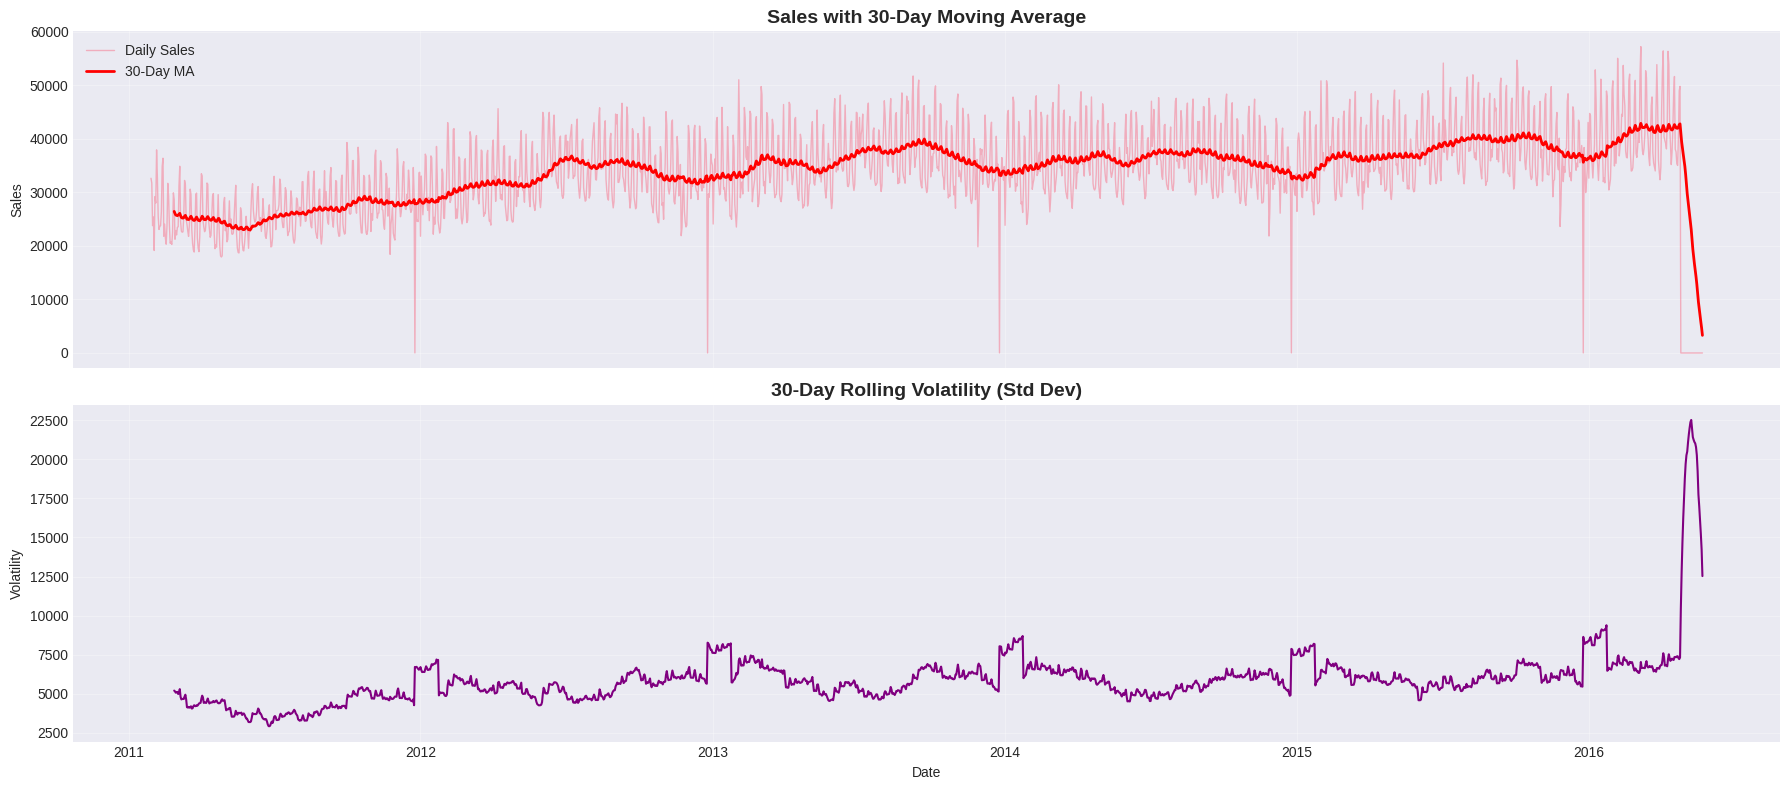


 Saved: 09_volatility_analysis.png


In [45]:
print("\n" + "="*80)
print(" SECTION 11: VOLATILITY ANALYSIS")
print("="*80)

daily["rolling_mean_30"] = daily.sales.rolling(30).mean()
daily["rolling_std_30"] = daily.sales.rolling(30).std()

print(f"\n11.1 Volatility Statistics:")
print("-" * 80)
print(f"  Average 30-Day Volatility: {daily.rolling_std_30.mean():,.2f}")
print(f"  Max 30-Day Volatility: {daily.rolling_std_30.max():,.2f}")
print(f"  Min 30-Day Volatility: {daily.rolling_std_30.min():,.2f}")

fig, axes = plt.subplots(2, 1, figsize=(18, 8), sharex=True)

axes[0].plot(daily.index, daily.sales, linewidth=1, alpha=0.5, label='Daily Sales')
axes[0].plot(daily.index, daily.rolling_mean_30, linewidth=2, color='red', label='30-Day MA')
axes[0].set_title("Sales with 30-Day Moving Average", fontsize=14, fontweight='bold')
axes[0].set_ylabel("Sales")
axes[0].legend()
axes[0].grid(alpha=0.3)

axes[1].plot(daily.index, daily.rolling_std_30, linewidth=1.5, color='purple')
axes[1].set_title("30-Day Rolling Volatility (Std Dev)", fontsize=14, fontweight='bold')
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Volatility")
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()
plt.savefig('09_volatility_analysis.png', bbox_inches='tight')
print("\n Saved: 09_volatility_analysis.png")
plt.close()


# **Changepoint Detection (Without Prophet)**


 Saved: 10_Changepoint Detection (Without Prophet).png


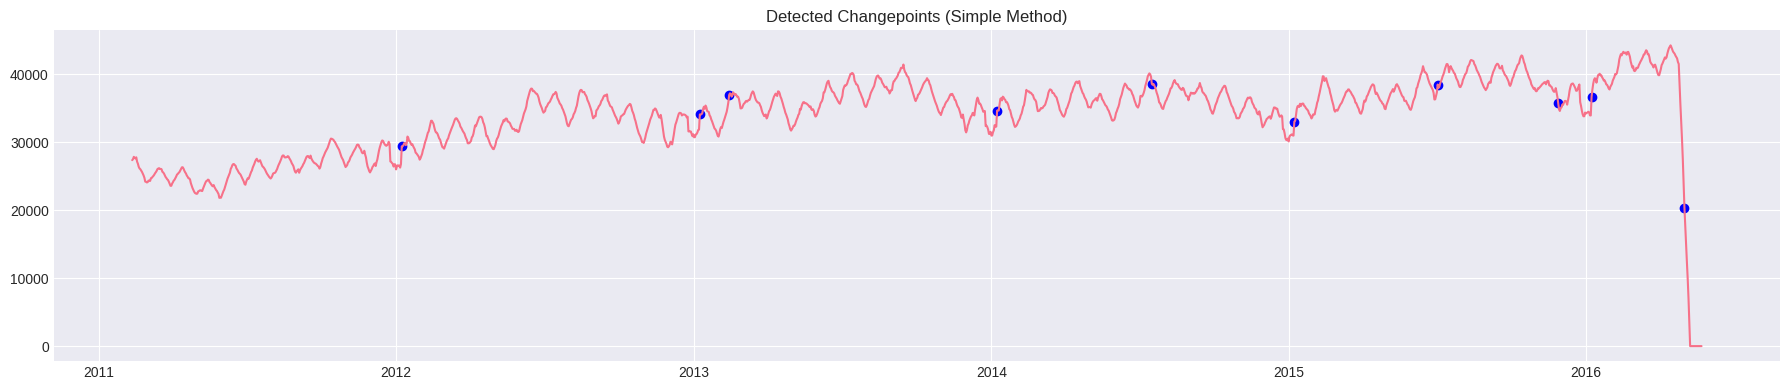

In [46]:
from scipy.signal import find_peaks

series = daily.sales.rolling(14).mean().dropna()

diff = series.diff().abs()
peaks, _ = find_peaks(diff, distance=30, height=diff.mean() * 3)

plt.figure(figsize=(18,4))
plt.plot(series.index, series)
plt.scatter(series.index[peaks], series.values[peaks], color="blue")
plt.title("Detected Changepoints (Simple Method)")
plt.tight_layout()
plt.savefig('10_volatility_analysis.png', bbox_inches='tight')
print("\n Saved: 10_Changepoint Detection (Without Prophet).png")
plt.show()
plt.close()

# **Analyze Long-Term Cyclic Patterns (>1 Year)**


 Saved: 11_Analyze Long-Term Cyclic Patterns (>1 Year).png


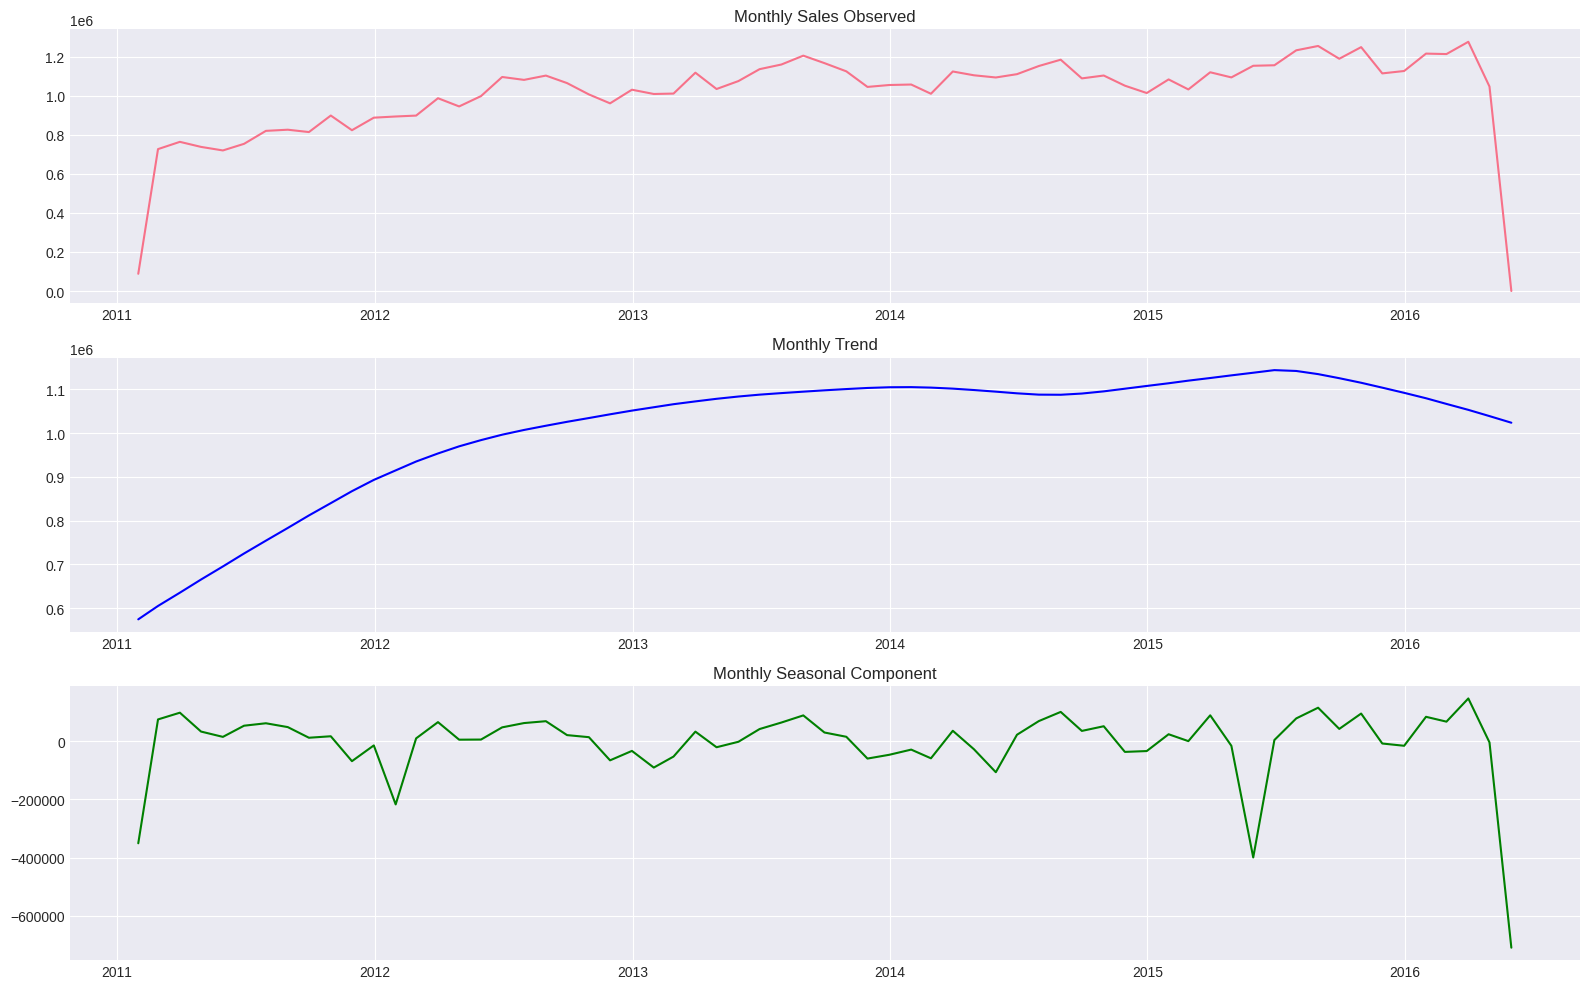

In [47]:
# Resample daily sales to monthly
monthly = daily['sales'].resample('M').sum()

# STL decomposition on monthly sales (seasonal period = 12 months)
stl_monthly = STL(monthly, period=12)
res_monthly = stl_monthly.fit()

plt.figure(figsize=(16,10))

plt.subplot(3,1,1)
plt.plot(monthly.index, monthly, label='Observed')
plt.title("Monthly Sales Observed")

plt.subplot(3,1,2)
plt.plot(monthly.index, res_monthly.trend, label='Trend', color='blue')
plt.title("Monthly Trend")

plt.subplot(3,1,3)
plt.plot(monthly.index, res_monthly.seasonal, label='Seasonal', color='green')
plt.title("Monthly Seasonal Component")

plt.tight_layout()
plt.savefig('11_Analyze Long-Term Cyclic Patterns (>1 Year).png', bbox_inches='tight')
print("\n Saved: 11_Analyze Long-Term Cyclic Patterns (>1 Year).png")
plt.show()
plt.close()

# **FINAL SUMMARY**

In [48]:
print("\n" + "="*80)
print(" EDA COMPLETE - SUMMARY")
print("="*80)

print(f"""
Generated Files:
  01_daily_sales_overview.png      - Sales time series & distribution
  02_stl_decomposition.png         - Trend, seasonal, residual
  03_acf_pacf.png                  - Autocorrelation analysis
  04_seasonality_patterns.png      - Weekly, monthly, yearly patterns
  05_event_impact.png              - Event vs normal days
  06_correlation_heatmap.png       - Feature correlations
  07_outliers.png                  - Outlier detection
  08_top_performers.png            - Top items & stores
  09_volatility_analysis.png       - Rolling volatility
  10_Changepoint Detection.png      -10_Changepoint Detection
  11_Analyze Long-Term Cyclic Patterns.png  -11 Analyze Long-Term Cyclic Patterns

Key Insights:
  • Total observations: {len(df):,}
  • Date range: {(df['date'].max() - df['date'].min()).days} days
  • Average daily sales: {daily.sales.mean():,.2f}
  • Outliers detected: {len(outliers)} ({len(outliers)/len(daily)*100:.2f}%)
  • Event uplift: {uplift:.2f}%
  • Stationarity: {('Yes' if adf_result[1] < 0.05 else 'No')}""")


 EDA COMPLETE - SUMMARY

Generated Files:
  01_daily_sales_overview.png      - Sales time series & distribution
  02_stl_decomposition.png         - Trend, seasonal, residual
  03_acf_pacf.png                  - Autocorrelation analysis
  04_seasonality_patterns.png      - Weekly, monthly, yearly patterns
  05_event_impact.png              - Event vs normal days
  06_correlation_heatmap.png       - Feature correlations
  07_outliers.png                  - Outlier detection
  08_top_performers.png            - Top items & stores
  09_volatility_analysis.png       - Rolling volatility
  10_Changepoint Detection.png      -10_Changepoint Detection
  11_Analyze Long-Term Cyclic Patterns.png  -11 Analyze Long-Term Cyclic Patterns

Key Insights:
  • Total observations: 59,181,090
  • Date range: 1940 days
  • Average daily sales: 33,846.17
  • Outliers detected: 47 (2.42%)
  • Event uplift: -6.46%
  • Stationarity: No
